In [17]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib notebook
import seaborn as sns
from sklearn.utils import resample
from sklearn.datasets import fetch_openml
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedShuffleSplit


# df = pd.read_csv('./data/heart.csv')
# df = df.dropna(axis=1)
# X = df.drop('target', axis=1)
# y = df['target']

dataset = fetch_openml(name="credit-g")
df = pd.DataFrame(data=np.c_[dataset['data'], dataset['target']],
                            columns=dataset['feature_names'] + ['target'])
print(df.shape)
df.head()

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn


(1000, 21)


<IPython.core.display.Javascript object>


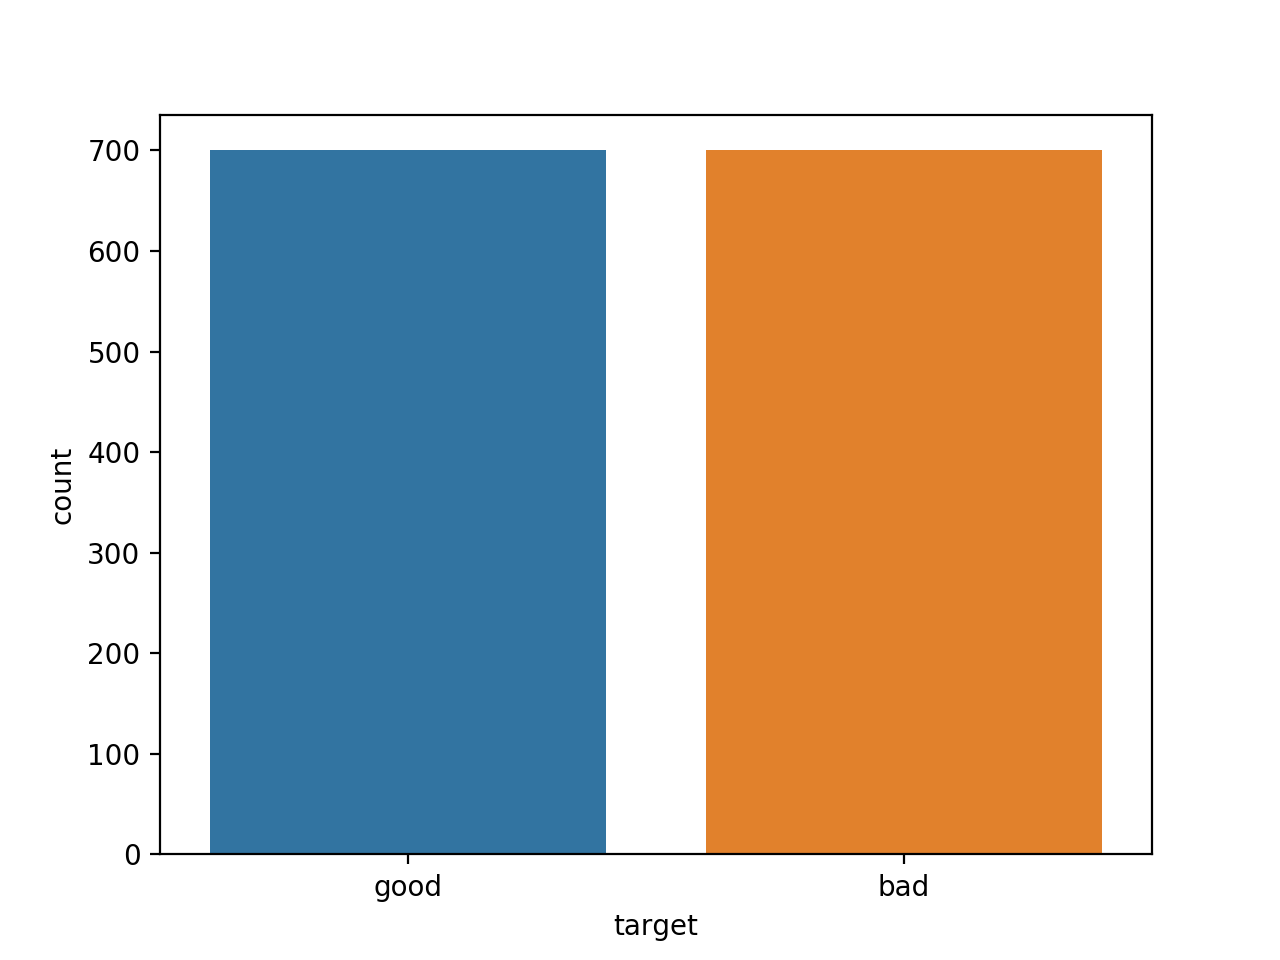

In [18]:
# df.target = pd.to_numeric(df.target, errors='coerce')
# df["target"] = df.target.map("{:02}".format)
sns.countplot(x="target", data=df)

In [19]:
df_majority = df[df.target=="good"]
df_minority = df[df.target=="bad"]
n_samples = df_majority.shape[0] - df_minority.shape[0]
df_up = resample(df_minority, replace=True, n_samples=n_samples, random_state=100)
df_up = pd.concat([df,df_up])
sns.countplot(x="target", data=df_up)

<IPython.core.display.Javascript object>


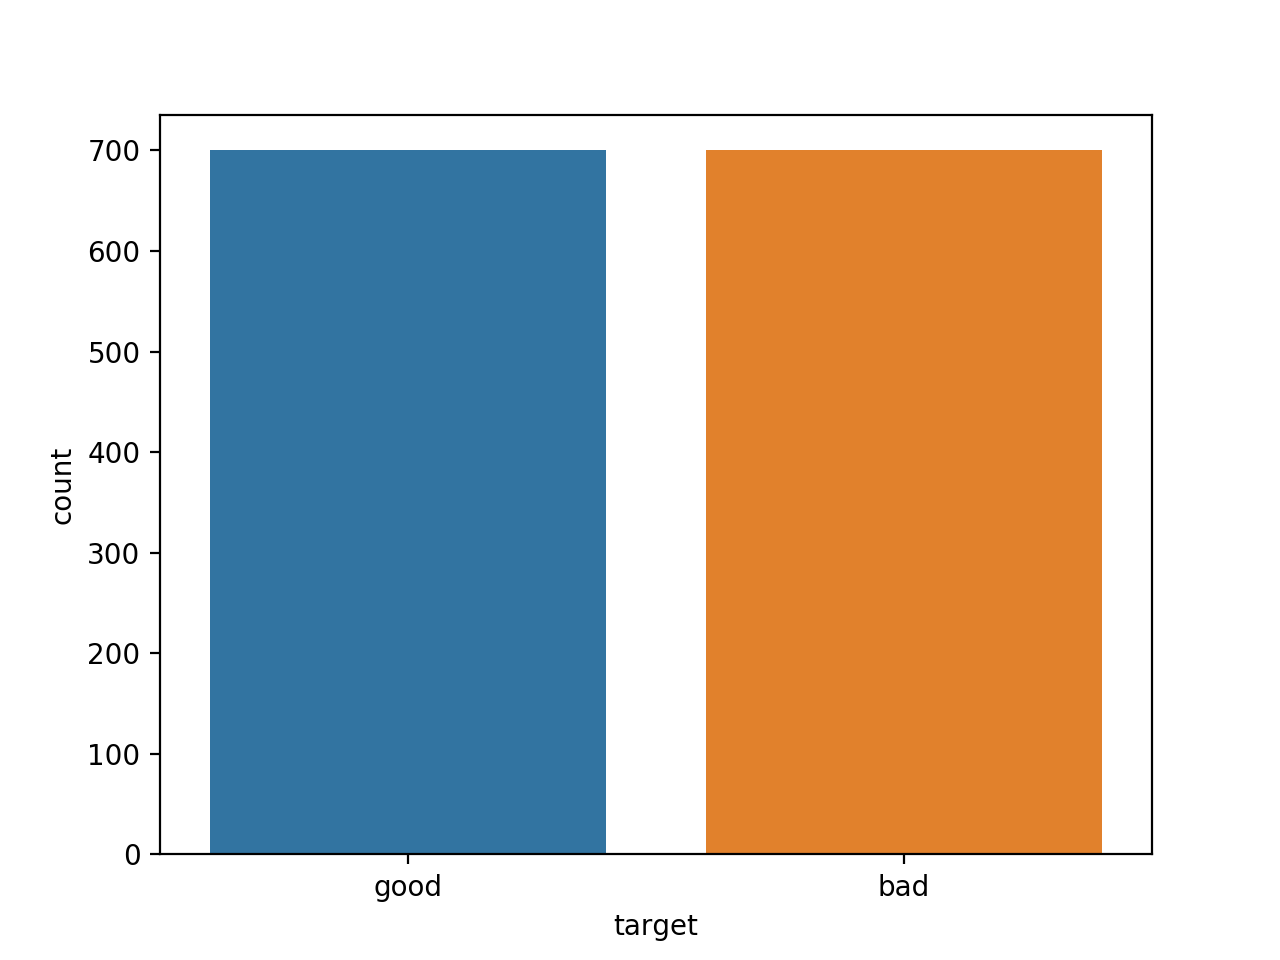

In [10]:
%matplotlib notebook
sns.countplot(x="target", data=df_up)

In [20]:
from sklearn.model_selection import train_test_split
X = df_up.drop('target', axis=1)
y = df_up['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=111, stratify=y)


def count_class(y):
    unique, counts = np.unique(y, return_counts=True)
    uqc = dict(zip(unique, counts))
    print(uqc)


count_class(y_train)


{'bad': 560, 'good': 560}


In [30]:
#Source: https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html
from sklearn.model_selection import learning_curve
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

def plot_learning_curve(estimator, title, X, y, scoring="accuracy"):
    
    cv=StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
    n_jobs=None
    train_sizes=np.linspace(.1, 1.0, 20)
    
    plt.figure()
    plt.title(title)
    plt.xlabel("Training Size")
    plt.ylabel(scoring)
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring=scoring)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-Validation score")

    plt.legend(loc="best")
    return plt

def plot_model_complexity_curve(estimator, title, X, y, param_grid, scoring="accuracy"):
    param = list(param_grid.keys())[0]

    cv=StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
    
    gs = GridSearchCV(estimator,
                  scoring=scoring,
                  cv=cv,
                  param_grid=param_grid)
    gs.fit(X, y)
    results = gs.cv_results_

    train_scores_mean = results[f"mean_train_score"]
    test_scores_mean = results[f"mean_test_score"]
    

    x_axis = results[f"param_{param}"].data
    new_axis = []
    for p in x_axis:
        if isinstance(p, tuple):
            j = '_'.join([str(x) for x in p])
            new_axis.append(j)
    if new_axis:
        x_axis = np.array(new_axis)
            
    plt.figure()
    plt.title(title)
    plt.xlabel(f"Model Complexity ({param})")
    plt.ylabel(scoring)
    plt.grid()
    plt.plot(x_axis, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(x_axis, test_scores_mean, 'o-', color="g",
             label="Cross-Validation score")
    plt.legend(loc="best")
    return plt  

def search_gridcv(estimator, X, y, param_grid, scoring="accuracy"):
    cv=StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
    gs = GridSearchCV(estimator,
                  scoring=scoring,
                  cv=cv,
                  param_grid=param_grid)
    gs.fit(X, y)
    results = gs.cv_results_
    print(gs.best_estimator_)
    print(gs.best_score_)
    print(gs.best_params_)
    
def boxplot_cv_scores(models, X, y, scoring=scoring):
    results = []
    names = []
    cv=StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
    for name, estimator in models:
        _results = cross_val_score(estimator, X, y, cv=cv, scoring=scoring)
        results.append(_results)
        names.append(name)
        print(f"{name}: {_results.mean()} ({_results.std()})")

    # boxplot for algorithm comparision
    fig = plt.figure()
    fig.suptitle("Algorithm Comparision")
    ax = fig.add_subplot(111)
    plt.boxplot(results)
    ax.set_xticklabels(names)
    plt.show()
    
def accuracy_score_report(models, X_train, y_train, X_test, y_test, scoring=scoring):
    for name, estimator in models:
        clf = estimator.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        score = accuracy_score(y_test, y_pred)
        report = classification_report(y_test, y_pred, target_names=["good", "bad"])
        print(f"{name}: {score}")


### Decision Tree

<IPython.core.display.Javascript object>


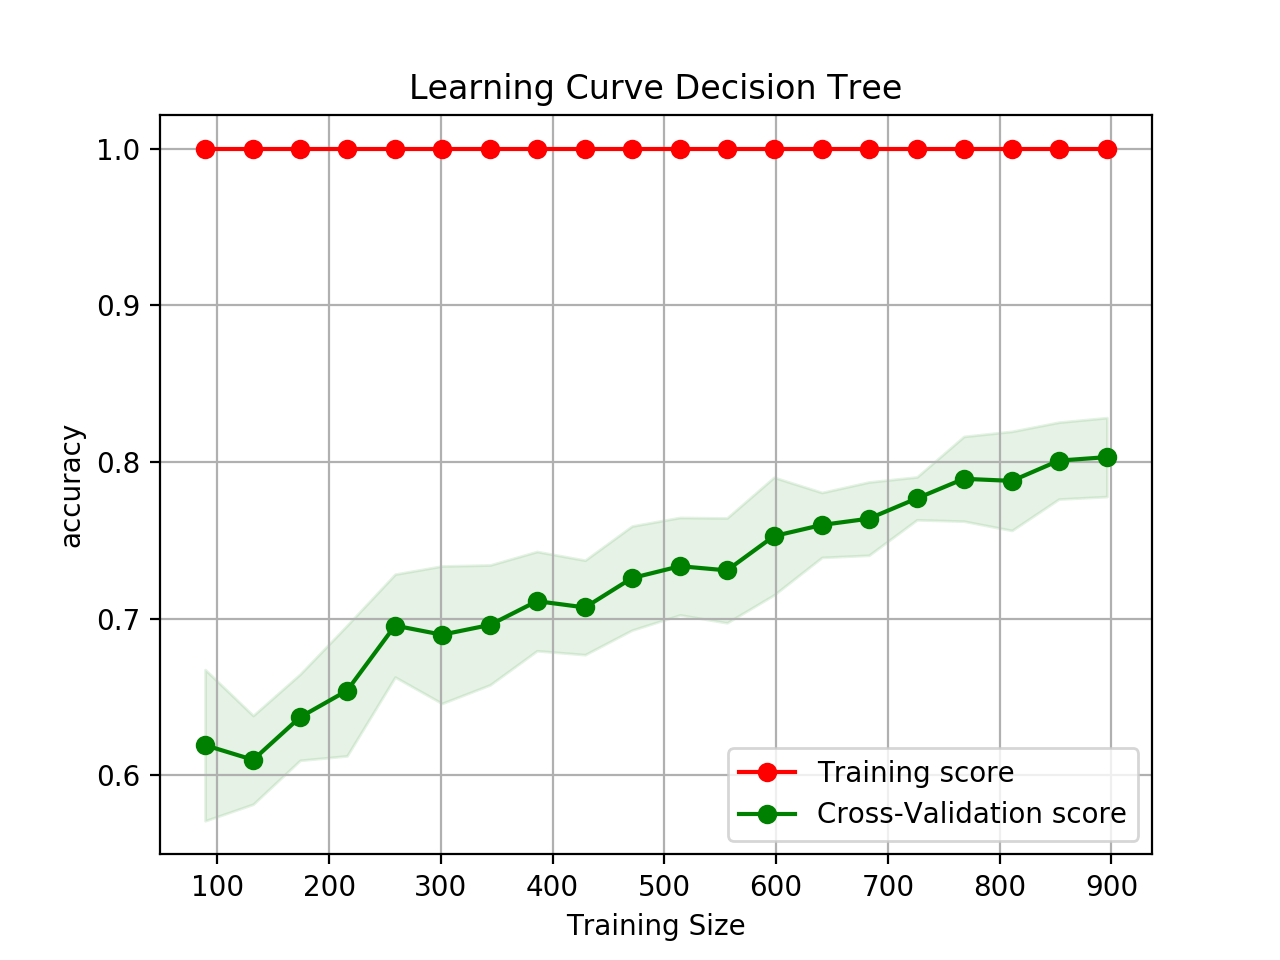

<module 'matplotlib.pyplot' from '/Users/bishwash.aryal/.local/lib/python3.6/site-packages/matplotlib/pyplot.py'>

In [91]:
from sklearn.tree import DecisionTreeClassifier
estimator = DecisionTreeClassifier()
plot_learning_curve(estimator, f"Learning Curve Decision Tree", X_train, y_train)

From the above given learning curve, we can see that the training score (red line) is at its maximum regardless of training size, this shows severe overfitting. Cross-Validation Score increases with traning size, but there is a huge gap between them, which indicates high variance scenario, therefore we need to reduce complexity of the model or gather more data. Since gathering more data is not possible, we need to reduce the complexity.

Pruning is one of the mechanisms for reducing complexity in a decision tree. Sklearn library currently doesn't support pruning but we can set maximum depth and samples required at leaf node to do some form of pre-pruning.


<IPython.core.display.Javascript object>


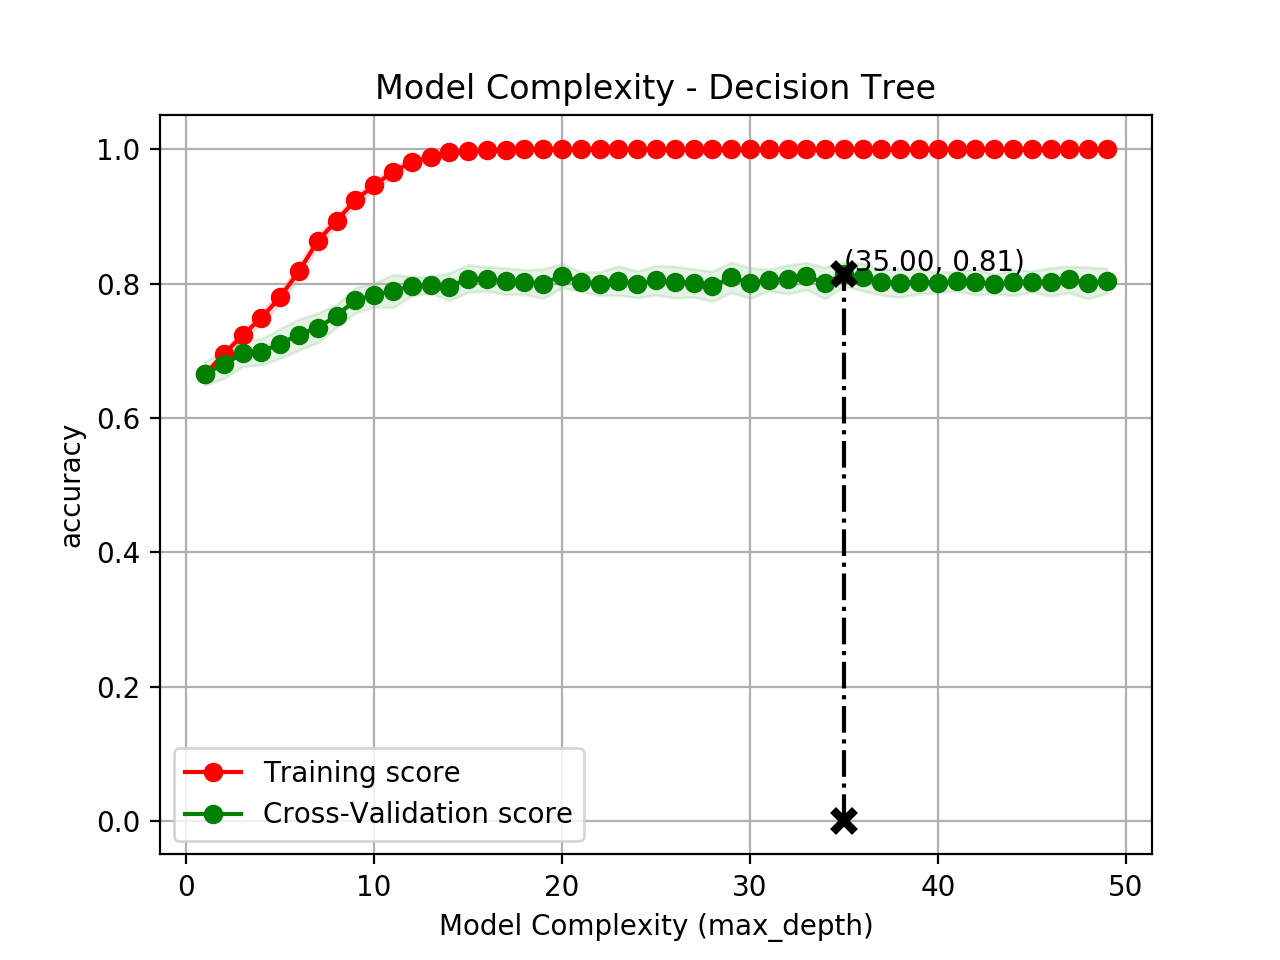

<IPython.core.display.Javascript object>


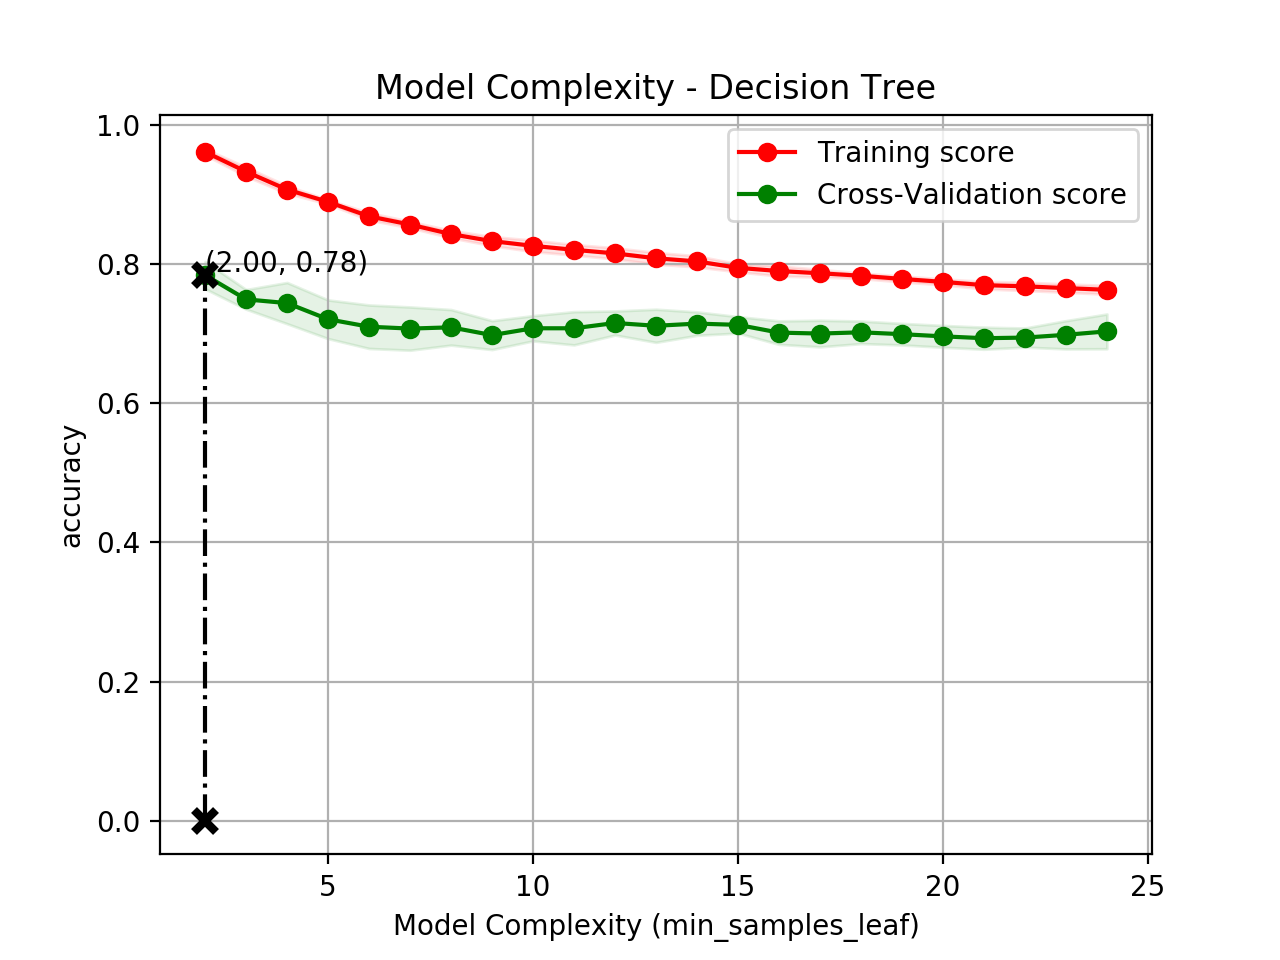

<module 'matplotlib.pyplot' from '/Users/bishwash.aryal/.local/lib/python3.6/site-packages/matplotlib/pyplot.py'>

In [116]:
#### Model Complexity - Decision Tree
estimator = DecisionTreeClassifier()
title = "Model Complexity - Decision Tree"
param_grid = {'max_depth': range(1, 50, 1)}
plot_model_complexity_curve(estimator, title, X_train, y_train, param_grid, scoring="accuracy")


estimator = DecisionTreeClassifier()
title = "Model Complexity - Decision Tree"
param_grid = {'min_samples_leaf': range(2, 25, 1)}
plot_model_complexity_curve(estimator, title, X_train, y_train, param_grid, scoring="accuracy")

# estimator = DecisionTreeClassifier()
# title = "Model Complexity - Decision Tree"
# param_grid = {'max_leaf_nodes': range(2, 100, 1)}
# plot_model_complexity_curve(estimator, title, X_train, y_train, param_grid, scoring="accuracy")

# all_param_grid = {
#     'max_depth': range(1, 50, 1),
#     'min_samples_leaf': range(2, 25, 1),
# }

# search_gridcv(estimator, X_train, y_train, all_param_grid, scoring="accuracy")

We have looked into individual hyperparameter, but the performance could change when these parameters are combined. Sklearn provides GridSearchCV which will help us iterate over the parameters to return the best performing combintation.


In [ ]:
estimator = DecisionTreeClassifier()

all_param_grid = {
    'max_depth': range(1, 50, 1),
    'min_samples_leaf': range(2, 25, 1),
}

search_gridcv(estimator, X_train, y_train, all_param_grid, scoring="accuracy")

<IPython.core.display.Javascript object>


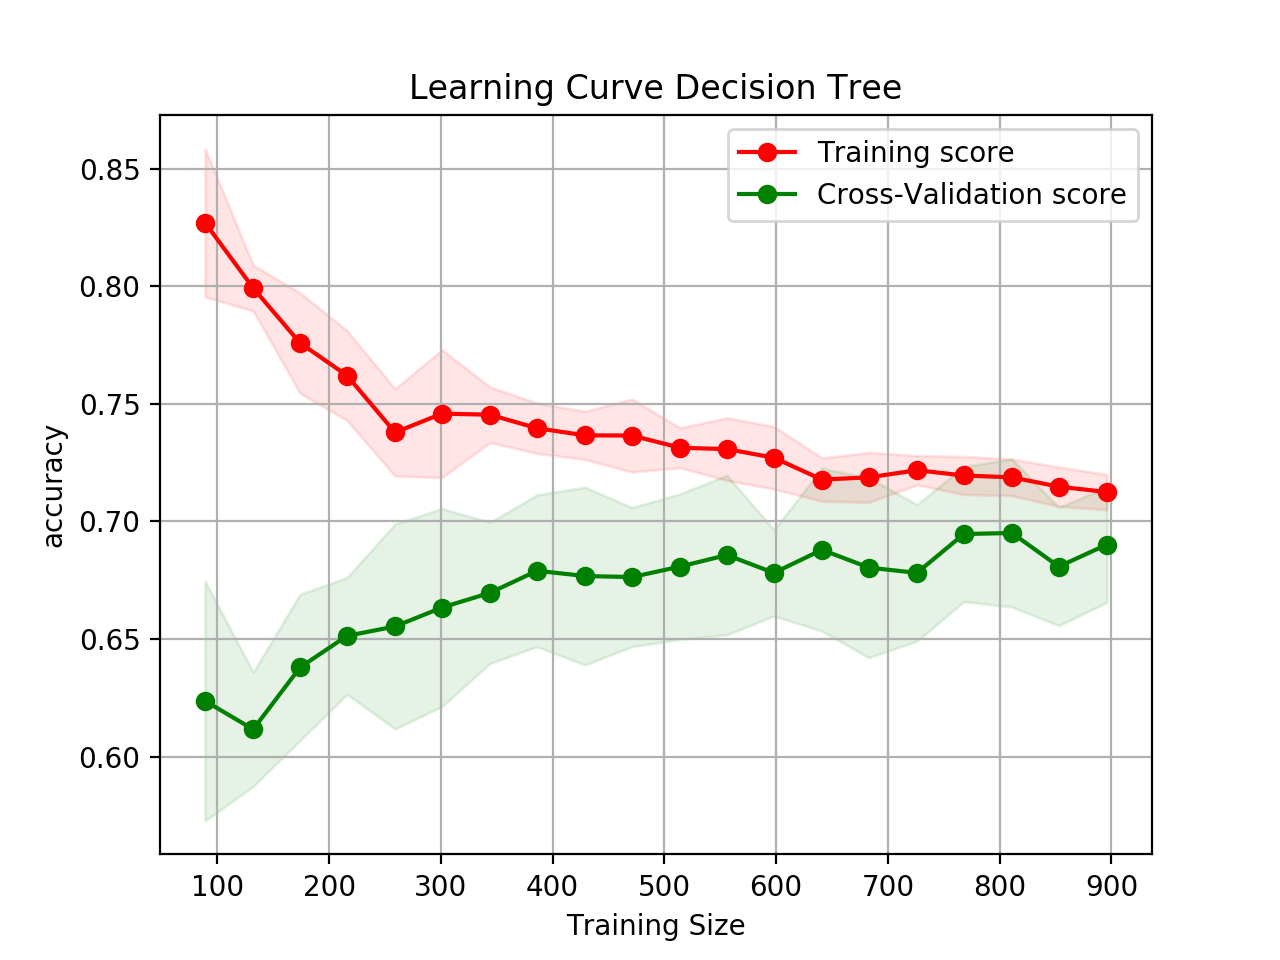

<module 'matplotlib.pyplot' from '/Users/bishwash.aryal/.local/lib/python3.6/site-packages/matplotlib/pyplot.py'>

In [103]:
from sklearn.tree import DecisionTreeClassifier
estimator = DecisionTreeClassifier(max_depth=20, min_samples_leaf=2, min_samples_split=0.2)
plot_learning_curve(estimator, f"Learning Curve Decision Tree", X_train, y_train)